
# Proyecto Capstone - La Batalla de los Vecindarios 

### Ciencia de datos aplicada Capstone por IBM/Coursera

La ciudad de Guadalajara en Jalisco, Mexico es de un a de las más visitadas. Dado su relevancia turistica, esta ciudad cuenta con diversos restaurantes para satisfacer las necesidades de los visitantes.

En este proyecto intentaremos encontrar una ubicación óptima para un restaurante. Es de interes encontrar el tipo de restaurantes mas comunes en la Ciudad de Guadalajara. En base a la informacion obtenida definir el restaurante con mallores probabilidades de exito. Debido a su frecuencia de aparicion alrededor del centro de giuadalajara, ya que implicaria el exito de este giro de comida.

Dado que hay muchos restaurantes en la ciudad de Guadalajara, intentaremos detectar **ubicaciones que aún no esten saturadas de restaurantes** pero  **lo más cerca posible del centro de la ciudad**.

Usaremos la ciencia de datos para generar zonas prometedoras de acuerdo a los criterios anteriores. 

Este proyecto esta dirigido a personas que esten interesados en abrir un restaurante pero no esten seguros del tema de comida en Guadalajara, Jalisco Mexico.


Según el planteamiento del problema:





* Encontrar los restaurantes con más frecuencia para proponerlo como posible negocio.
* número de restaurantes existentes al rededor de zonas 
* distancia del barrio al centro de la ciudad

Se selecciona una zona alrededor de la ciudad. Esa zona se divide en sub zonas para investigar cuáles son las áreas más factibles para el negocio.

Se necesitarán las siguientes fuentes de datos para extraer/generar la información requerida:

* Los centros de las áreas candidatas se generarán algorítmicamente.
* la cantidad de restaurantes y su tipo y ubicación en cada zona se obtendrá usando `API de Foursquare`.

* La coordenada del centro de Guadalajara se obtiene por `geolocator.

* Las distancias son calculadas por `geopy.distance`.




###Cargamos Modulos necesarios

In [ ]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# Install website scraping libraries and packages in Python from BeautifulSoup 
!conda install -c conda-forge beautifulsoup4 --yes  # uncomment this line if you haven't completed 
from bs4 import BeautifulSoup as bs

print('Libraries imported.')

/bin/bash: conda: command not found
/bin/bash: conda: command not found
/bin/bash: conda: command not found
Libraries imported.


https://latitude.to/map/mx/mexico/cities/guadalajara

Encontremos la latitud y longitud del centro de la ciudad de Guadalajara, utilizando **geolocator.geocode** por su direccion.

In [ ]:
address = "Guadalajara, Jalisco, Mexico"
geo_agent = "Guadalajara_explorer"

geolocator = Nominatim(user_agent=geo_agent)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are : {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Guadalajara, Jalisco, Mexico are : 20.6720375, -103.338396.


In [ ]:
gdl_center = [latitude, longitude]

Ahora vamos a crear una areas candidatas, igualmente espaciadas, centradas alrededor del centro de la ciudad.Las areas tienen radio de 300 metros. Usamos una funcion para para convertir entre el sistema de coordenadas esféricas WGS84 (grados de latitud/longitud) y el sistema de coordenadas cartesianas UTM (coordenadas X/Y en metros)




In [ ]:
!pip install shapely
import shapely.geometry

!pip install pyproj
import pyproj

import math

def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

print('Coordinate transformation check')
print('-------------------------------')
print('Berlin center longitude={}, latitude={}'.format(gdl_center[1], gdl_center[0]))
x, y = lonlat_to_xy(gdl_center[1], gdl_center[0])
print('Berlin center UTM X={}, Y={}'.format(x, y))
lo, la = xy_to_lonlat(x, y)
print('Berlin center longitude={}, latitude={}'.format(lo, la))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 5.1 MB/s 
Coordinate transformation check
-------------------------------
Berlin center longitude=-103.338396, latitude=20.6720375
Berlin center UTM X=-6951170.559471042, Y=15714736.938613715
Berlin center longitude=-103.33839599999193, latitude=20.672037499997167


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


In [ ]:
gdl_center_x, gdl_center_y = lonlat_to_xy(gdl_center[1], gdl_center[0]) # City center in Cartesian coordinates

k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_min = gdl_center_x - 6000
x_step = 600
y_min = gdl_center_y - 6000 - (int(21/k)*k*600 - 12000)/2
y_step = 600 * k 

latitudes = []
longitudes = []
distances_from_center = []
xs = []
ys = []
for i in range(0, int(21/k)):
    y = y_min + i * y_step
    x_offset = 30 if i%2==0 else 0
    for j in range(0, 21):
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(gdl_center_x, gdl_center_y, x, y)
        if (distance_from_center <= 3001):
            lon, lat = xy_to_lonlat(x, y)
            latitudes.append(lat)
            longitudes.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)

print(len(latitudes), 'candidate neighborhood centers generated.')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io

88 candidate neighborhood centers generated.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.h

In [ ]:
[latitudes[0], longitudes[0]]



[20.679718728214315, -103.32516025845817]

In [ ]:
columns = ['Zone', 'latitudes', 'longitudes']

df_gdl = pd.DataFrame(columns=columns)
df_gdl



Empty DataFrame
Columns: [Zone, latitudes, longitudes]
Index: []

In [ ]:
len(latitudes)

88

In [ ]:
for i in range(len(latitudes)):
    df_gdl = df_gdl.append({"Zone":  "zone " + str(i), 'latitudes': latitudes[i], 'longitudes': longitudes[i]},ignore_index=True)
df_gdl.head(10)

Zone  latitudes  longitudes
0  zone 0  20.679719 -103.325160
1  zone 1  20.681415 -103.327877
2  zone 2  20.683111 -103.330594
3  zone 3  20.684807 -103.333311
4  zone 4  20.686503 -103.336029
5  zone 5  20.675894 -103.324140
6  zone 6  20.677589 -103.326857
7  zone 7  20.679285 -103.329574
8  zone 8  20.680981 -103.332291
9  zone 9  20.682677 -103.335008

Visualicemos los datos que tenemos hasta ahora: ubicación del centro de la ciudad y centros de barrio candidatos:

In [ ]:
address = "Guadalajara, Jalisco, Mexico"
geo_agent = "Guadalajara_explorer"

geolocator = Nominatim(user_agent=geo_agent)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are : {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Guadalajara, Jalisco, Mexico are : 20.6720375, -103.338396.


In [ ]:
#!pip install folium

import folium

Luego, proyectaremoslas coordenadas en grados de latitud/longitud para que se muestren en el mapa de `Folium`.

In [ ]:
my_map = folium.Map(location=gdl_center, zoom_start=13)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(my_map)

folium.Marker(gdl_center, popup='Guadalajara Centro').add_to(my_map)
for lat, lon in zip(df_gdl['latitudes'], df_gdl['longitudes']):
    folium.Circle([lat, lon], radius=170, color='red', fill=False).add_to(my_map)
folium.Circle(gdl_center, radius=1901, color='blue', fill=False).add_to(my_map)
my_map


### Foresquare

Ahora que tenemos ubicaciones candidatas, usemos la API de Foursquare para obtener información sobre restaurantes en cada vecindario.

Estamos interesados en conocer cuales son los comercios mas comunes, por lo que
nos aseguraremos de detectar e incluir todas las subcategorías de la categoría específica de 'comida', ya que necesitamos información sobre los restaurantes en la zona.

In [ ]:
#CLIENT_ID = 'ZXVHU04MAOWIQZBZHQNHBOBYWKU3TOZMCLBHKOEU41JJGE03' # your Foursquare ID
#CLIENT_SECRET = 'Y5GSJIVY2SHHS2X3YLZXXQR2E3HUSBZ0TMC31LA3UHT5LPPV' # your Foursquare Secret

#CLIENT_ID = 'XZ0AFZKEED3PJ2KUS050XXJ0PARO5IUT1SH0VEAPHDKIGNM3' # your Foursquare ID
#CLIENT_SECRET = 'MCWNXHME2GND2V2D3IRYYRAGB1XW2FXRLFRXXBAQ133SMOZD' # your Foursquare Secret

CLIENT_ID = '0RVTYD1VK2FA522PAZNV0O0SLWVRLZBVCHXXG3VCPXKTPM3Y' # your Foursquare ID!!!!!!!!!
CLIENT_SECRET = 'LDRZ1G3S2XW5GIO45L0L0ONSCZ0WUVKPOKGHKXJH544EKABH' # your Foursquare Secret!!!!!!
VERSION = '20180605' # Foursquare API version

#VERSION = '20180605' # Foursquare API version
#VERSION = '20210604'
#LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0RVTYD1VK2FA522PAZNV0O0SLWVRLZBVCHXXG3VCPXKTPM3Y
CLIENT_SECRET:LDRZ1G3S2XW5GIO45L0L0ONSCZ0WUVKPOKGHKXJH544EKABH


In [ ]:
neighborhood_latitude = df_gdl.loc[0, 'latitudes'] # neighborhood latitude value
neighborhood_longitude = df_gdl.loc[0, 'longitudes'] # neighborhood longitude value

neighborhood_name = df_gdl.loc[0, 'Zone'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

NameError: ignored

In [ ]:
#  Answer here
radius = 170
LIMIT = 100
#url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    neighborhood_latitude, neighborhood_longitude,
    VERSION,
    radius,
    LIMIT)
url


In [ ]:
# make the GET request
results = requests.get(url).json()
print(results)

In [ ]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [ ]:
venues = results['response']["groups"][0]['items']
#venues = results['response']
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

In [ ]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

In [ ]:
print(nearby_venues)

In [ ]:
map_venues = folium.Map(location=gdl_center, zoom_start=13)
folium.Marker(gdl_center, popup='Guadalajara Centro').add_to(map_venues)

for lat, lon in zip(df_gdl['latitudes'], df_gdl['longitudes']):
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
    folium.Circle([lat, lon], radius=170, color='blue', fill=False).add_to(map_venues)

for lat, lon in zip(nearby_venues['lat'], nearby_venues['lng']):
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
    folium.Circle([lat, lon], radius=10, color='red', fill=False).add_to(map_venues)
    #folium.Marker([lat, lon]).add_to(map_berlin)
folium.Circle(gdl_center, radius=1601, color='green', fill=False).add_to(map_venues)
map_venues

In [ ]:
nearby_venues.to_csv("zone 0 venues.csv")

#toronto_data.to_csv('canada_postal_code_list.csv')

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zone', 
                  'Zone Latitude', 
                  'Zone Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
# Create toronto_venues dataframe conatining a
gdl_venues = getNearbyVenues(names= df_gdl['Zone'],
                                   latitudes= df_gdl['latitudes'],
                                   longitudes= df_gdl['longitudes']
                                  )



In [ ]:
gdl_venues.to_csv("gdl_venues.csv")

In [ ]:
gdl_venues = pd.read_csv('gdl_venues.csv')  

In [ ]:
print(len(gdl_venues['Venue Category'].unique()))

137


#Metodología

En este proyecto se propuso detectarun area de oportunidad de negocio, especificamente restaurantes. En áreas de la zona centro de Guadañajara que tengan una baja densidad de restaurantes del mismo giro. Limitaremos nuestro análisis al área de ~6 km alrededor del centro de la ciudad.

En el primer paso, se recopilo datos probenientes de consultas a Fopresquare. Se realizó la ubicacion de restarunates y negocios alrededor de cada zona propuesta en pasos anteriores. Los datos obtenidos en general son ubicación y tipo (categoría) de cada restaurante.


el siguiente paso es obtener los restaurantes con mayor frecuencia por la zona cenro de laciudad con la finalidad de proponer uno o dos temas de comida para un restaurante.

Una ves seleccionado los posibles negocios se filtraran todos los restaurantes con mayor frecuencia de la zona, descartando asi la mayoria de locales por la zona y solamente observar los de interes.


se calculara la distancia que tiene cada uno de los restaurantes a la zona centro y la cercania a otros restaurantes del mismo tipo en un zona alrededor de 250m a la redonda.




Finalmente, nos centraremos en las áreas más prometedoras y dentro de ellas crearemos **grupos de ubicaciones**, tomaremos en consideración ubicaciones con **no demasiados restaurantes en un radio de 250 metros**. Esta clasificacion la realizaremos por medio de **k-means clustering** y separar en tres categorias. Zonas muy densas en restaurantes. Zonas muy desoladas y zonas con numeros de restaurantes moderos. Siendo esta ultima clase la de mayor interés para nuestra investigaión.


#Analisis

Realicemos un análisis de datos explicativo básico y obtengamos información adicional de nuestros datos sin procesar.Primero observemos algunos de los datos obtenidos.

In [ ]:
gdl_venues.head(20)

Unnamed: 0    Zone  Zone Latitude  Zone Longitude  \
0            0  zone 0      20.679719      -103.32516   
1            1  zone 0      20.679719      -103.32516   
2            2  zone 0      20.679719      -103.32516   
3            3  zone 0      20.679719      -103.32516   
4            4  zone 0      20.679719      -103.32516   
5            5  zone 0      20.679719      -103.32516   
6            6  zone 0      20.679719      -103.32516   
7            7  zone 0      20.679719      -103.32516   
8            8  zone 0      20.679719      -103.32516   
9            9  zone 0      20.679719      -103.32516   
10          10  zone 0      20.679719      -103.32516   
11          11  zone 0      20.679719      -103.32516   
12          12  zone 0      20.679719      -103.32516   
13          13  zone 0      20.679719      -103.32516   
14          14  zone 0      20.679719      -103.32516   
15          15  zone 0      20.679719      -103.32516   
16          16  zone 0      20.679719      -103.32516   
17          17  zone 0      20.679719      -103.32516   
18          18  zone 0      20.679719      -103.32516   
19          19  zone 0      20.679719      -103.32516   

                                             Venue  Venue Latitude  \
0                                     Tortas danny       20.679181   
1      taqueria los charros (Taqueria Los Charros)       20.680708   
2                Panadería La Perlita de Occidente       20.678966   
3                         El Siete Y Medio De Paco       20.678159   
4                               Carnes Asadas Fili       20.680322   
5                                         Mascusia       20.678008   
6                              Mariscos Los Amigos       20.676075   
7                                    Vinos giralda       20.680670   
8                                  Tacos Don Mario       20.681504   
9   Tortas y tacos El güero y su cazo de fritangas       20.681867   
10                              Carnes Asadas Mode       20.681058   
11                               Menudería Chipres       20.682759   
12                            Farmacia Guadalajara       20.678984   
13                               Farmacia El Globo       20.682699   
14                                       Mama Lola       20.681580   
15                           Armadillo Restaurante       20.680555   
16                                            OXXO       20.681403   
17                           Mariscos El Cocodrilo       20.675645   
18                                            Oxxo       20.676822   
19                     Emotion Life Fitness Center       20.676981   

    Venue Longitude        Venue Category  
0       -103.323992        Sandwich Place  
1       -103.327542            Restaurant  
2       -103.328051                Bakery  
3       -103.322078    Seafood Restaurant  
4       -103.321226    Mexican Restaurant  
5       -103.327853                   Bar  
6       -103.323003    Seafood Restaurant  
7       -103.326489          Liquor Store  
8       -103.328743            Taco Place  
9       -103.327289            Taco Place  
10      -103.321752            Taco Place  
11      -103.326833    Mexican Restaurant  
12      -103.328084              Pharmacy  
13      -103.327938              Pharmacy  
14      -103.325984                Bakery  
15      -103.320792    Mexican Restaurant  
16      -103.321909     Convenience Store  
17      -103.323384    Seafood Restaurant  
18      -103.328215     Convenience Store  
19      -103.321799  Gym / Fitness Center

Mostrar Ubicacion de los Comercios

In [ ]:
map_venues = folium.Map(location=gdl_center, zoom_start=13)
folium.Marker(gdl_center, popup='Guadalajara Centro').add_to(map_venues)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(map_venues)

for lat, lon in zip(df_gdl['latitudes'], df_gdl['longitudes']):
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
    folium.Circle([lat, lon], radius=170, color='blue', fill=False).add_to(map_venues)

for lat, lon in zip(gdl_venues['Venue Latitude'], gdl_venues['Venue Longitude']):
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
    folium.Circle([lat, lon], radius=10, color='red', fill=False).add_to(map_venues)
    #folium.Marker([lat, lon]).add_to(map_berlin)
folium.Circle(gdl_center, radius=1900, color='#9FF3E8', fill=True, fill_opacity=0.6).add_to(map_venues)
map_venues

Se puede Observar que la cantidad de restaurantes por la zona es prometedora, debido a que los negocios prosperan por la zona debido a su alta densidad.

#Analiza cada barrio

####agrupemos las filas por vecindario y tomando la media de la frecuencia de ocurrencia de cada categoría

In [ ]:
# one hot encoding
gdl_onehot = pd.get_dummies(gdl_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
gdl_onehot['Zone'] = gdl_venues['Zone'] 

# move neighborhood column to the first column
fixed_columns = [gdl_onehot.columns[-1]] + list(gdl_onehot.columns[:-1])
gdl_onehot = gdl_onehot[fixed_columns]

gdl_onehot.head()

Zone  Amphitheater  Arcade  Art Gallery  Art Museum  Arts & Crafts Store  \
0  zone 0             0       0            0           0                    0   
1  zone 0             0       0            0           0                    0   
2  zone 0             0       0            0           0                    0   
3  zone 0             0       0            0           0                    0   
4  zone 0             0       0            0           0                    0   

   Arts & Entertainment  Asian Restaurant  BBQ Joint  Baby Store  Bakery  \
0                     0                 0          0           0       0   
1                     0                 0          0           0       0   
2                     0                 0          0           0       1   
3                     0                 0          0           0       0   
4                     0                 0          0           0       0   

   Bank  Bar  Bed & Breakfast  Beer Garden  Big Box Store  \
0     0    0                0            0              0   
1     0    0                0            0              0   
2     0    0                0            0              0   
3     0    0                0            0              0   
4     0    0                0            0              0   

   Bike Rental / Bike Share  Bistro  Board Shop  Bookstore  Boutique  \
0                         0       0           0          0         0   
1                         0       0           0          0         0   
2                         0       0           0          0         0   
3                         0       0           0          0         0   
4                         0       0           0          0         0   

   Breakfast Spot  Brewery  Bubble Tea Shop  Burger Joint  Bus Line  Café  \
0               0        0                0             0         0     0   
1               0        0                0             0         0     0   
2               0        0                0             0         0     0   
3               0        0                0             0         0     0   
4               0        0                0             0         0     0   

   Candy Store  Capitol Building  Cheese Shop  Church  Circus  City Hall  \
0            0                 0            0       0       0          0   
1            0                 0            0       0       0          0   
2            0                 0            0       0       0          0   
3            0                 0            0       0       0          0   
4            0                 0            0       0       0          0   

   Clothing Store  Coffee Shop  College Administrative Building  \
0               0            0                                0   
1               0            0                                0   
2               0            0                                0   
3               0            0                                0   
4               0            0                                0   

   College Library  Comedy Club  Comfort Food Restaurant  Concert Hall  \
0                0            0                        0             0   
1                0            0                        0             0   
2                0            0                        0             0   
3                0            0                        0             0   
4                0            0                        0             0   

   Convenience Store  Cupcake Shop  Dairy Store  Dance Studio  \
0                  0             0            0             0   
1                  0             0            0             0   
2                  0             0            0             0   
3                  0             0            0             0   
4                  0             0            0             0   

   Department Store  Design Studio  Dessert Shop  Diner  \
0                 0              0         

In [ ]:
gdl_onehot.shape

(2867, 138)

In [ ]:
gdl_grouped = gdl_onehot.groupby('Zone').mean().reset_index()
gdl_grouped

Zone  Amphitheater    Arcade  Art Gallery  Art Museum  \
0    zone 0      0.000000  0.000000     0.000000    0.000000   
1    zone 1      0.000000  0.000000     0.000000    0.000000   
2   zone 10      0.000000  0.000000     0.000000    0.000000   
3   zone 11      0.000000  0.000000     0.000000    0.000000   
4   zone 12      0.000000  0.000000     0.000000    0.000000   
5   zone 13      0.000000  0.000000     0.000000    0.000000   
6   zone 14      0.000000  0.000000     0.000000    0.000000   
7   zone 15      0.000000  0.000000     0.000000    0.000000   
8   zone 16      0.000000  0.000000     0.000000    0.000000   
9   zone 17      0.000000  0.000000     0.000000    0.000000   
10  zone 18      0.000000  0.000000     0.000000    0.000000   
11  zone 19      0.000000  0.000000     0.000000    0.000000   
12   zone 2      0.000000  0.000000     0.000000    0.000000   
13  zone 20      0.000000  0.000000     0.000000    0.000000   
14  zone 21      0.000000  0.000000     0.000000    0.000000   
15  zone 22      0.000000  0.000000     0.000000    0.000000   
16  zone 23      0.000000  0.000000     0.000000    0.000000   
17  zone 24      0.000000  0.000000     0.000000    0.000000   
18  zone 25      0.000000  0.000000     0.000000    0.000000   
19  zone 26      0.000000  0.000000     0.000000    0.000000   
20  zone 27      0.000000  0.000000     0.021277    0.000000   
21  zone 28      0.000000  0.000000     0.026316    0.026316   
22  zone 29      0.000000  0.000000     0.000000    0.016393   
23   zone 3      0.000000  0.000000     0.000000    0.000000   
24  zone 30      0.000000  0.000000     0.000000    0.000000   
25  zone 31      0.000000  0.000000     0.000000    0.000000   
26  zone 32      0.000000  0.000000     0.000000    0.000000   
27  zone 33      0.000000  0.000000     0.000000    0.000000   
28  zone 34      0.000000  0.000000     0.000000    0.000000   
29  zone 35      0.000000  0.000000     0.000000    0.000000   
30  zone 36      0.000000  0.000000     0.011111    0.022222   
31  zone 37      0.000000  0.000000     0.010000    0.020000   
32  zone 38      0.000000  0.000000     0.011628    0.023256   
33  zone 39      0.000000  0.000000     0.000000    0.000000   
34   zone 4      0.000000  0.000000     0.000000    0.000000   
35  zone 40      0.000000  0.000000     0.000000    0.000000   
36  zone 41      0.000000  0.000000     0.000000    0.000000   
37  zone 42      0.000000  0.000000     0.000000    0.000000   
38  zone 43      0.000000  0.000000     0.000000    0.000000   
39  zone 44      0.000000  0.000000     0.000000    0.000000   
40  zone 45      0.000000  0.000000     0.000000    0.000000   
41  zone 46      0.000000  0.000000     0.015625    0.000000   
42  zone 47      0.000000  0.000000     0.010000    0.020000   
43  zone 48      0.000000  0.000000     0.010000    0.020000   
44  zone 49      0.000000  0.000000     0.000000    0.000000   
45   zone 5      0.000000  0.000000     0.000000    0.000000   
46  zone 50      0.000000  0.000000     0.000000    0.000000   
47  zone 51      0.000000  0.000000     0.000000    0.000000   
48  zone 52      0.000000  0.000000     0.000000    0.000000   
49  zone 53      0.000000  0.000000     0.000000    0.000000   
50  zone 54      0.000000  0.000000     0.000000    0.000000   
51  zone 55      0.020000  0.000000     0.000000    0.000000   
52  zone 56      0.010000  0.010000     0.010000    0.010000   
53  zone 57      0.000000  0.010101     0.010101    0.010101   
54  zone 58      0.000000  0.000000     0.000000    0.000000   
55  zone 59      0.000000  0.000000     0.000000    0.000000   
56   zone 6      0.000000  0.000000     0.000000    0.000000   
57  zone 60      0.000000  0.000000     0.000000    0.000000   
58  zone 61      0.000000  0.000000     0.000000    0.000000   
59  zone 62      0.000000  0.000000     0.000000    0.000000   
60  zone 63      0.037037  0.000000     0.000000    0.000000   
61  zone 64      0.013333  0.000000    

In [ ]:
gdl_grouped.shape

(88, 138)

### 5 lugares más comunes

In [ ]:
num_top_venues = 5

for hood in gdl_grouped['Zone']:
    print("----"+hood+"----")
    temp = gdl_grouped[gdl_grouped['Zone'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----zone 0----
                venue  freq
0          Taco Place  0.12
1  Seafood Restaurant  0.12
2  Mexican Restaurant  0.12
3              Bakery  0.12
4            Pharmacy  0.08


----zone 1----
            venue  freq
0        Pharmacy  0.17
1      Taco Place  0.17
2             Bar  0.08
3    Liquor Store  0.08
4  Sandwich Place  0.08


----zone 10----
                venue  freq
0          Taco Place  0.18
1  Mexican Restaurant  0.14
2   Convenience Store  0.09
3          Restaurant  0.09
4         Wings Joint  0.05


----zone 11----
                     venue  freq
0               Taco Place  0.20
1       Mexican Restaurant  0.20
2           Breakfast Spot  0.07
3                Pet Store  0.07
4  Comfort Food Restaurant  0.07


----zone 12----
                venue  freq
0          Taco Place  0.18
1  Seafood Restaurant  0.14
2  Mexican Restaurant  0.14
3         Flea Market  0.09
4           Juice Bar  0.05


----zone 13----
                venue  freq
0  Mexican Restaurant 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6fe9298910>],
      dtype=object)

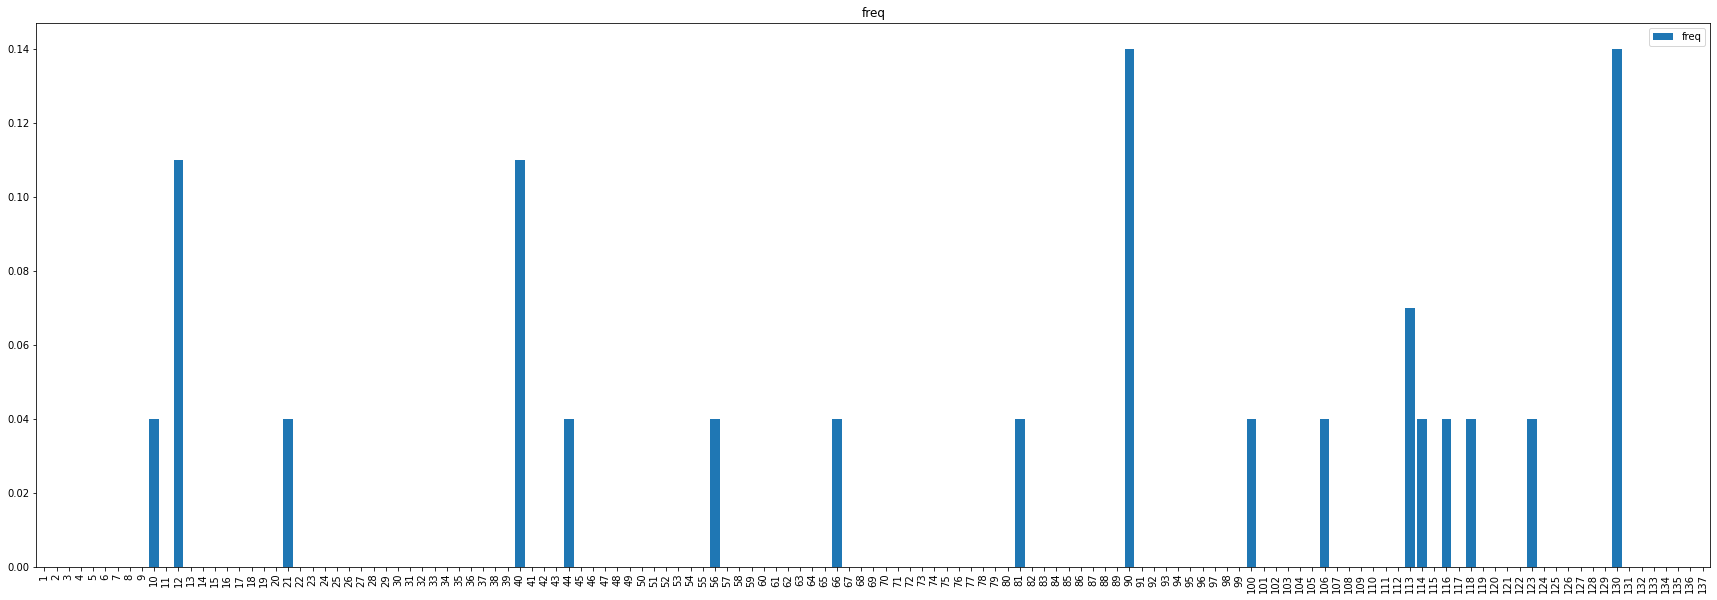

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

temp.plot(kind = 'bar',
             width=0.8,
             subplots=True,
             figsize=(30,10))

In [ ]:
temp.loc[[90,130],:]

venue  freq
90   Mexican Restaurant  0.14
130          Taco Place  0.14

Ordenar

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

##crear el nuevo frame de datos y mostrar los mejores lugares para cada vecindario

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zone']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zone_venues_sorted = pd.DataFrame(columns=columns)
zone_venues_sorted['Zone'] = gdl_grouped['Zone']

for ind in np.arange(gdl_grouped.shape[0]):
    zone_venues_sorted.iloc[ind, 1:] = return_most_common_venues(gdl_grouped.iloc[ind, :], num_top_venues)

zone_venues_sorted.head(10)

Zone 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0   zone 0            Taco Place    Seafood Restaurant    Mexican Restaurant   
1   zone 1              Pharmacy            Taco Place                   Bar   
2  zone 10            Taco Place    Mexican Restaurant     Convenience Store   
3  zone 11            Taco Place    Mexican Restaurant        Breakfast Spot   
4  zone 12            Taco Place    Seafood Restaurant    Mexican Restaurant   
5  zone 13    Mexican Restaurant    Seafood Restaurant            Taco Place   
6  zone 14              Pharmacy                Bakery     Convenience Store   
7  zone 15              Pharmacy                Bakery     Convenience Store   
8  zone 16            Taco Place    Mexican Restaurant      Department Store   
9  zone 17    Mexican Restaurant         Jewelry Store        Sandwich Place   

  4th Most Common Venue    5th Most Common Venue 6th Most Common Venue  \
0                Bakery                 Pharmacy     Convenience Store   
1          Liquor Store           Sandwich Place                   Gym   
2            Restaurant              Wings Joint              Boutique   
3             Pet Store  Comfort Food Restaurant              Boutique   
4           Flea Market                Juice Bar     Convenience Store   
5              Pharmacy              Flea Market     Convenience Store   
6    Mexican Restaurant               Taco Place          Burger Joint   
7                   Bar             Burger Joint     Electronics Store   
8    Seafood Restaurant                Juice Bar                Garden   
9            Restaurant               Taco Place    Seafood Restaurant   

     7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0           Breakfast Spot             Pet Store            Restaurant   
1       Mexican Restaurant                Bakery      Sushi Restaurant   
2  Comfort Food Restaurant             Pet Store                   Pub   
3             Optical Shop           Coffee Shop                Bakery   
4              Fish Market            Restaurant                   Spa   
5             Dance Studio                Bakery                   Spa   
6        Electronics Store                   Bar           Flea Market   
7       Mexican Restaurant   Monument / Landmark                 Motel   
8       Italian Restaurant   Martial Arts School         Grocery Store   
9        Convenience Store        Ice Cream Shop      Pedestrian Plaza   

        10th Most Common Venue  
0                 Liquor Store  
1                   Restaurant  
2                  Salad Place  
3                          Pub  
4  Eastern European Restaurant  
5                  Fish Market  
6                 Optical Shop  
7              Motorcycle Shop  
8                          Gym  
9             Department Store

Obtenemos Los comercios con mayor frecuencia en la zona. Se puede observar que los locales donde venden comida Mexicana y Tacos son los mas habituales. Por lo que podemos proponer un restaurante para Tacos o Comida mexicana, inclusive ambos.

In [ ]:
gdl_frecuency = zone_venues_sorted.iloc[:, 1]

list_vanues = gdl_frecuency.values.tolist()
a = pd.unique(list_vanues)
len(a)
for i in range(len(a)):
  count = gdl_frecuency[:].str.count(a[i])
  print(f"{a[i]} esta contenida", end=" ")
  print(count.sum())

Taco Place esta contenida 14
Pharmacy esta contenida 5
Mexican Restaurant esta contenida 43
Convenience Store esta contenida 5
Comedy Club esta contenida 1
Plaza esta contenida 2
Café esta contenida 1
Seafood Restaurant esta contenida 3
Sporting Goods Shop esta contenida 1
Hot Dog Joint esta contenida 1
Hotel esta contenida 3
Bakery esta contenida 2
Market esta contenida 1
Ice Cream Shop esta contenida 1
Bar esta contenida 4
Department Store esta contenida 1


###Filtramos los negocios con categoria (según Foresquare) "Taco place" y "Mexican Restaurant".

In [ ]:
temp = gdl_venues[gdl_venues['Venue Category'] == "Taco Place"].T.reset_index()
  
#temp.columns = ['venue','freq']
gdl_frec_res = temp
gdl_frec_res

index                8  \
0       Unnamed: 0                8   
1             Zone           zone 0   
2    Zone Latitude        20.679719   
3   Zone Longitude       -103.32516   
4            Venue  Tacos Don Mario   
5   Venue Latitude        20.681504   
6  Venue Longitude      -103.328743   
7   Venue Category       Taco Place   

                                                9                  10  \
0                                               9                  10   
1                                          zone 0              zone 0   
2                                       20.679719           20.679719   
3                                      -103.32516          -103.32516   
4  Tortas y tacos El güero y su cazo de fritangas  Carnes Asadas Mode   
5                                       20.681867           20.681058   
6                                     -103.327289         -103.321752   
7                                      Taco Place          Taco Place   

                26                                              30  \
0               26                                              30   
1           zone 1                                          zone 1   
2        20.681415                                       20.681415   
3      -103.327877                                     -103.327877   
4  Tacos Don Mario  Tortas y tacos El güero y su cazo de fritangas   
5        20.681504                                       20.681867   
6      -103.328743                                     -103.327289   
7       Taco Place                                      Taco Place   

                41              43  \
0               41              43   
1           zone 2          zone 2   
2        20.683111       20.683111   
3      -103.330594     -103.330594   
4  Tacos Don Mario  Tacos Don Luis   
5        20.681504       20.682093   
6      -103.328743     -103.333854   
7       Taco Place      Taco Place   

                                               46              63  \
0                                              46              63   
1                                          zone 2          zone 3   
2                                       20.683111       20.684807   
3                                     -103.330594     -103.333311   
4  Tortas y tacos El güero y su cazo de fritangas  Tacos Don Luis   
5                                       20.681867       20.682093   
6                                     -103.327289     -103.333854   
7                                      Taco Place      Taco Place   

                           64                           66  \
0                          64                           66   
1                      zone 3                       zone 3   
2                   20.684807                    20.684807   
3                 -103.333311                  -103.333311   
4  Birria de Res "Los Cuates"  Tacos de Barbacoa "El Gera"   
5                   20.684887                    20.685131   
6                 -103.337026                  -103.337598   
7                  Taco Place                   Taco Place   

                                74                    76  \
0                               74                    76   
1                           zone 3                zone 3   
2                        20.684807             20.684807   
3                      -103.333311           -103.333311   
4  tacos al pastor fuente olimpica  Tacos De La Olimpica   
5                        20.688331             20.688358   
6                      -103.335079           -103.335148   
7                       Taco Place            Taco Place   

                           83                           85  \
0                          83                           85   
1                      zone 4                       zone 4   
2                   20.686503                    20.686503   
3                 -103.336029                  -103.336029 

In [ ]:
temp = gdl_venues[gdl_venues['Venue Category'] == "Mexican Restaurant"].T.reset_index()
  
#temp.columns = ['venue','freq']
gdl_frec_res1 = temp
gdl_frec_res1.T[4]
#gdl_frec_res1.T.head()
gdl_frec_res1.T.drop(["index"],axis=0)

0        1          2           3  \
4        4   zone 0  20.679719  -103.32516   
11      11   zone 0  20.679719  -103.32516   
15      15   zone 0  20.679719  -103.32516   
29      29   zone 1  20.681415 -103.327877   
44      44   zone 2  20.683111 -103.330594   
47      47   zone 2  20.683111 -103.330594   
53      53   zone 3  20.684807 -103.333311   
56      56   zone 3  20.684807 -103.333311   
59      59   zone 3  20.684807 -103.333311   
60      60   zone 3  20.684807 -103.333311   
82      82   zone 4  20.686503 -103.336029   
84      84   zone 4  20.686503 -103.336029   
87      87   zone 4  20.686503 -103.336029   
90      90   zone 4  20.686503 -103.336029   
122    122   zone 5  20.675894  -103.32414   
145    145   zone 6  20.677589 -103.326857   
159    159   zone 7  20.679285 -103.329574   
169    169   zone 7  20.679285 -103.329574   
181    181   zone 8  20.680981 -103.332291   
187    187   zone 8  20.680981 -103.332291   
198    198   zone 9  20.682677 -103.335008   
199    199   zone 9  20.682677 -103.335008   
215    215   zone 9  20.682677 -103.335008   
216    216   zone 9  20.682677 -103.335008   
219    219  zone 10  20.684373 -103.337726   
229    229  zone 10  20.684373 -103.337726   
230    230  zone 10  20.684373 -103.337726   
250    250  zone 11   20.68607 -103.340443   
251    251  zone 11   20.68607 -103.340443   
253    253  zone 11   20.68607 -103.340443   
257    257  zone 12  20.671899 -103.322848   
261    261  zone 12  20.671899 -103.322848   
274    274  zone 12  20.671899 -103.322848   
281    281  zone 13  20.673595 -103.325565   
283    283  zone 13  20.673595 -103.325565   
295    295  zone 13  20.673595 -103.325565   
301    301  zone 14   20.67529 -103.328281   
319    319  zone 15  20.676986 -103.330998   
326    326  zone 16  20.678682 -103.333715   
328    328  zone 16  20.678682 -103.333715   
334    334  zone 17  20.680378 -103.336433   
350    350  zone 17  20.680378 -103.336433   
359    359  zone 17  20.680378 -103.336433   
364    364  zone 17  20.680378 -103.336433   
366    366  zone 18  20.682074 -103.339151   
377    377  zone 18  20.682074 -103.339151   
385    385  zone 19   20.68377 -103.341868   
390    390  zone 19   20.68377 -103.341868   
394    394  zone 19   20.68377 -103.341868   
398    398  zone 20  20.685466 -103.344587   
408    408  zone 20  20.685466 -103.344587   
409    409  zone 20  20.685466 -103.344587   
411    411  zone 20  20.685466 -103.344587   
414    414  zone 20  20.685466 -103.344587   
416    416  zone 20  20.685466 -103.344587   
417    417  zone 20  20.685466 -103.344587   
418    418  zone 20  20.685466 -103.344587   
428    428  zone 21   20.66977 -103.324544   
432    432  zone 21   20.66977 -103.324544   
436    436  zone 21   20.66977 -103.324544   
443    443  zone 21   20.66977 -103.324544   
450    450  zone 22  20.671466 -103.327261   
453    453  zone 22  20.671466 -103.327261   
464    464  zone 22  20.671466 -103.327261   
468    468  zone 23  20.673161 -103.329977   
470    470  zone 23  20.673161 -103.329977   
471    471  zone 23  20.673161 -103.329977   
483    483  zone 24  20.674856 -103.332694   
484    484  zone 24  20.674856 -103.332694   
486    486  zone 24  20.674856 -103.332694   
493    493  zone 24  20.674856 -103.332694   
510    510  zone 25  20.676552 -103.335412   
526    526  zone 25  20.676552 -103.335412   
527    527  zone 25  20.676552 -103.335412   
530    530  zone 25  20.676552 -103.335412   
538    538  zone 26  20.678248 -103.338129   
545    545  zone 26  20.678248 -103.338129   
558    558  zone 26  20.678248 -103.338129   
562    562  zone 26  20.678248 -103.338129   
563    563  zone 26  20.678248 -103.338129   
566    566  zone 26  20.678248 -103.338129   
568    568  zone 26  20.678248 -103.338129   
578    578  zone 26  20.678248 -103.338129   
584    584  zone 26  20.678248 -103.338129   
591    591  zone 27  20.679943 -103.340847   
602    602  zone 27  20.679943 -103.340847   
611    

In [ ]:
gdl_frec_res1=gdl_frec_res1.T
gdl_frec_res1 = gdl_frec_res1.drop(["index"])
gdl_frec_res1.head()

0       1          2           3                         4          5  \
4    4  zone 0  20.679719  -103.32516        Carnes Asadas Fili  20.680322   
11  11  zone 0  20.679719  -103.32516         Menudería Chipres  20.682759   
15  15  zone 0  20.679719  -103.32516     Armadillo Restaurante  20.680555   
29  29  zone 1  20.681415 -103.327877         Menudería Chipres  20.682759   
44  44  zone 2  20.683111 -103.330594  Gorditas Las Rancheritas   20.68511   

             6                   7  
4  -103.321226  Mexican Restaurant  
11 -103.326833  Mexican Restaurant  
15 -103.320792  Mexican Restaurant  
29 -103.326833  Mexican Restaurant  
44 -103.333837  Mexican Restaurant

In [ ]:
gdl_frec_res=gdl_frec_res.T
gdl_frec_res = gdl_frec_res.drop(["index"])
gdl_frec_res.head()

0       1          2           3  \
8    8  zone 0  20.679719  -103.32516   
9    9  zone 0  20.679719  -103.32516   
10  10  zone 0  20.679719  -103.32516   
26  26  zone 1  20.681415 -103.327877   
30  30  zone 1  20.681415 -103.327877   

                                                 4          5           6  \
8                                  Tacos Don Mario  20.681504 -103.328743   
9   Tortas y tacos El güero y su cazo de fritangas  20.681867 -103.327289   
10                              Carnes Asadas Mode  20.681058 -103.321752   
26                                 Tacos Don Mario  20.681504 -103.328743   
30  Tortas y tacos El güero y su cazo de fritangas  20.681867 -103.327289   

             7  
8   Taco Place  
9   Taco Place  
10  Taco Place  
26  Taco Place  
30  Taco Place

###Agrupamos ambos DataFrames obtenidos del filtrado.

In [ ]:
a = pd.concat([gdl_frec_res, gdl_frec_res1], axis=0)
a = a.drop(0, axis=1)
a


1          2           3  \
8      zone 0  20.679719  -103.32516   
9      zone 0  20.679719  -103.32516   
10     zone 0  20.679719  -103.32516   
26     zone 1  20.681415 -103.327877   
30     zone 1  20.681415 -103.327877   
41     zone 2  20.683111 -103.330594   
43     zone 2  20.683111 -103.330594   
46     zone 2  20.683111 -103.330594   
63     zone 3  20.684807 -103.333311   
64     zone 3  20.684807 -103.333311   
66     zone 3  20.684807 -103.333311   
74     zone 3  20.684807 -103.333311   
76     zone 3  20.684807 -103.333311   
83     zone 4  20.686503 -103.336029   
85     zone 4  20.686503 -103.336029   
99     zone 4  20.686503 -103.336029   
101    zone 4  20.686503 -103.336029   
108    zone 4  20.686503 -103.336029   
120    zone 5  20.675894  -103.32414   
128    zone 5  20.675894  -103.32414   
141    zone 6  20.677589 -103.326857   
144    zone 6  20.677589 -103.326857   
154    zone 7  20.679285 -103.329574   
155    zone 7  20.679285 -103.329574   
172    zone 8  20.680981 -103.332291   
178    zone 8  20.680981 -103.332291   
193    zone 9  20.682677 -103.335008   
197    zone 9  20.682677 -103.335008   
201    zone 9  20.682677 -103.335008   
206    zone 9  20.682677 -103.335008   
220   zone 10  20.684373 -103.337726   
222   zone 10  20.684373 -103.337726   
232   zone 10  20.684373 -103.337726   
235   zone 10  20.684373 -103.337726   
242   zone 11   20.68607 -103.340443   
245   zone 11   20.68607 -103.340443   
249   zone 11   20.68607 -103.340443   
255   zone 12  20.671899 -103.322848   
256   zone 12  20.671899 -103.322848   
267   zone 12  20.671899 -103.322848   
268   zone 12  20.671899 -103.322848   
277   zone 13  20.673595 -103.325565   
284   zone 13  20.673595 -103.325565   
291   zone 13  20.673595 -103.325565   
300   zone 14   20.67529 -103.328281   
322   zone 16  20.678682 -103.333715   
325   zone 16  20.678682 -103.333715   
339   zone 17  20.680378 -103.336433   
352   zone 17  20.680378 -103.336433   
369   zone 18  20.682074 -103.339151   
371   zone 18  20.682074 -103.339151   
373   zone 18  20.682074 -103.339151   
378   zone 18  20.682074 -103.339151   
379   zone 19   20.68377 -103.341868   
389   zone 19   20.68377 -103.341868   
399   zone 20  20.685466 -103.344587   
429   zone 21   20.66977 -103.324544   
430   zone 21   20.66977 -103.324544   
439   zone 21   20.66977 -103.324544   
447   zone 22  20.671466 -103.327261   
458   zone 22  20.671466 -103.327261   
474   zone 23  20.673161 -103.329977   
487   zone 24  20.674856 -103.332694   
516   zone 25  20.676552 -103.335412   
523   zone 25  20.676552 -103.335412   
531   zone 25  20.676552 -103.335412   
581   zone 26  20.678248 -103.338129   
587   zone 26  20.678248 -103.338129   
608   zone 27  20.679943 -103.340847   
635   zone 27  20.679943 -103.340847   
638   zone 28  20.681639 -103.343565   
691   zone 29  20.683335 -103.346283   
697   zone 29  20.683335 -103.346283   
738   zone 30  20.667472 -103.325968   
739   zone 30  20.667472 -103.325968   
747   zone 30  20.667472 -103.325968   
753   zone 31  20.669167 -103.328685   
762   zone 31  20.669167 -103.328685   
777   zone 32  20.670862 -103.331402   
791   zone 33  20.672557 -103.334119   
831   zone 34  20.674252 -103.336836   
851   zone 34  20.674252 -103.336836   
977   zone 36  20.677643 -103.342272   
1057  zone 37  20.679339  -103.34499   
1100  zone 38  20.681035 -103.347708   
1134  zone 38  20.681035 -103.347708   
1167  zone 39  20.663647 -103.324947   
1169  zone 39  20.663647 -103.324947   
1170  zone 39  20.663647 -103.324947   
1171  zone 39  20.663647 -103.324947   
1181  zone 40  20.665342 -103.327664   
1183  zone 40  20.665342 -103.327664   
1200  zone 41  20.667037  -103.33038   
1205  zone 41  20.667037  -103.33038   
1207  zone 41  20.667037  -103.33038   
1224  zone 42  20.668732 -103.333097   
1225  zone 42  20.668732 -103.333097   
1270  zone 43  20.670427 -103.335814   
1295  zone 44  20.672122 -103.338532   
1443  zone 4

### Mostramos los restaurantes con Categoria "Taco Place" y "Mexican Restaurant" en el mapa.

In [ ]:
map_venues = folium.Map(location=gdl_center, zoom_start=13)
folium.Marker(gdl_center, popup='Guadalajara Centro').add_to(map_venues)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(map_venues)

for lat, lon in zip(df_gdl['latitudes'], df_gdl['longitudes']):
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
    folium.Circle([lat, lon], radius=170, color='blue', fill=False).add_to(map_venues)

for lat, lon in zip(a[5], a[6]):
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
    folium.Circle([lat, lon], radius=10, color='red', fill=False).add_to(map_venues)
    #folium.Marker([lat, lon]).add_to(map_berlin)

folium.Circle(gdl_center, radius=1800, color='#9FF3E8', fill=True, fill_opacity=0.6).add_to(map_venues)
map_venues

#Distancia al centro y Restaurantes cercanos


##Restaurantes cercanos

Calculamos la cantidad de Restaurantes cecanos a cada negocio en un radio de 250 m para utilizarlos como metrica en el Clustering

In [ ]:
from geopy.distance import geodesic 
a = a.reset_index()
count = []
for lat, lon in zip(a[2], a[3]):
  con = 0
  for lat1, lon1 in zip(a[5], a[6]):
    x=(lat,lon)
    y=(lat1,lon1)
    dist = geodesic(x,y)
    if dist <=.25:
      con = con+1
  count.append(con)
  #print(count)

count = pd.DataFrame(count)

In [ ]:
gdl_near = pd.concat([a, count], axis=1)
gdl_near.head()

index       1          2           3  \
0      8  zone 0  20.679719  -103.32516   
1      9  zone 0  20.679719  -103.32516   
2     10  zone 0  20.679719  -103.32516   
3     26  zone 1  20.681415 -103.327877   
4     30  zone 1  20.681415 -103.327877   

                                                4          5           6  \
0                                 Tacos Don Mario  20.681504 -103.328743   
1  Tortas y tacos El güero y su cazo de fritangas  20.681867 -103.327289   
2                              Carnes Asadas Mode  20.681058 -103.321752   
3                                 Tacos Don Mario  20.681504 -103.328743   
4  Tortas y tacos El güero y su cazo de fritangas  20.681867 -103.327289   

            7   0  
0  Taco Place   0  
1  Taco Place   0  
2  Taco Place   0  
3  Taco Place  15  
4  Taco Place  15

## Distancia al Centro

Calculamos la distancia de cada uno de los Restaurantes al centro de la ciudad para utilizarlos como metrica en el Clustering

In [ ]:
from geopy.distance import geodesic 
dist = []
for lat, lon in zip(a[5], a[6]):
  x=(lat,lon)
  d = geodesic(x,gdl_center)
  dist.append(d)
  #print(count)

dist = pd.DataFrame(dist)

In [ ]:
dist.rename(columns={0:'distancia centro'},
               inplace=True)


dist.head()


distancia centro
0  1.4526084972674773 km
1  1.5885417652297769 km
2   2.001189758382035 km
3  1.4526084972674773 km
4  1.5885417652297769 km

## Agrupamos la información en el DataFrame

In [ ]:

gdl_near = pd.concat([gdl_near, dist], axis=1)
#a = a.drop(0, axis=1)


In [ ]:
gdl_near.head()

index       1          2           3  \
0      8  zone 0  20.679719  -103.32516   
1      9  zone 0  20.679719  -103.32516   
2     10  zone 0  20.679719  -103.32516   
3     26  zone 1  20.681415 -103.327877   
4     30  zone 1  20.681415 -103.327877   

                                                4          5           6  \
0                                 Tacos Don Mario  20.681504 -103.328743   
1  Tortas y tacos El güero y su cazo de fritangas  20.681867 -103.327289   
2                              Carnes Asadas Mode  20.681058 -103.321752   
3                                 Tacos Don Mario  20.681504 -103.328743   
4  Tortas y tacos El güero y su cazo de fritangas  20.681867 -103.327289   

            7   0       distancia centro  
0  Taco Place   0  1.4526084972674773 km  
1  Taco Place   0  1.5885417652297769 km  
2  Taco Place   0   2.001189758382035 km  
3  Taco Place  15  1.4526084972674773 km  
4  Taco Place  15  1.5885417652297769 km

In [ ]:
#temporal = gdl_near[:]
#temporal.rename(columns={1:'Zone',2:'zone latitud',3:'zone longitud', 4:'venue',5:'venue latitud',6:'venue longitud',0:'restaurantes cercanos'},inplace=True)
temporal.rename(columns={7:'categoria'},inplace=True)

temporal.head(10)

index    Zone zone latitud zone longitud  \
0      8  zone 0    20.679719    -103.32516   
1      9  zone 0    20.679719    -103.32516   
2     10  zone 0    20.679719    -103.32516   
3     26  zone 1    20.681415   -103.327877   
4     30  zone 1    20.681415   -103.327877   
5     41  zone 2    20.683111   -103.330594   
6     43  zone 2    20.683111   -103.330594   
7     46  zone 2    20.683111   -103.330594   
8     63  zone 3    20.684807   -103.333311   
9     64  zone 3    20.684807   -103.333311   

                                            venue venue latitud  \
0                                 Tacos Don Mario     20.681504   
1  Tortas y tacos El güero y su cazo de fritangas     20.681867   
2                              Carnes Asadas Mode     20.681058   
3                                 Tacos Don Mario     20.681504   
4  Tortas y tacos El güero y su cazo de fritangas     20.681867   
5                                 Tacos Don Mario     20.681504   
6                                  Tacos Don Luis     20.682093   
7  Tortas y tacos El güero y su cazo de fritangas     20.681867   
8                                  Tacos Don Luis     20.682093   
9                      Birria de Res "Los Cuates"     20.684887   

  venue longitud   categoria  restaurantes cercanos       distancia centro  
0    -103.328743  Taco Place                      0  1.4526084972674773 km  
1    -103.327289  Taco Place                      0  1.5885417652297769 km  
2    -103.321752  Taco Place                      0   2.001189758382035 km  
3    -103.328743  Taco Place                     15  1.4526084972674773 km  
4    -103.327289  Taco Place                     15  1.5885417652297769 km  
5    -103.328743  Taco Place                      0  1.4526084972674773 km  
6    -103.333854  Taco Place                      0  1.2096810703467684 km  
7    -103.327289  Taco Place                      0  1.5885417652297769 km  
8    -103.333854  Taco Place                      6  1.2096810703467684 km  
9    -103.337026  Taco Place                      6  1.4298022950903397 km

## 4. Cluster Neighborhoods

Usamos *k*-mean para agrupar el vecindario en 3 grupos.

In [ ]:
# set number of clusters
kclusters = 3

a_clustering = gdl_near.drop(['index',1,2,3,4,5,6,7], axis=1)
a_clustering['distancia centro'] = a_clustering['distancia centro'].astype(str).str[:-3].astype(float)#.str.replace("km", "")#.apply(float)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(a_clustering)

# check cluster labels generated for each row in the dataframe
print ("cluster labels are :", kmeans.labels_[0:10])
a_clustering.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


cluster labels are : [1 1 1 0 0 1 1 1 1 1]


0  distancia centro
0   0          1.452608
1   0          1.588542
2   0          2.001190
3  15          1.452608
4  15          1.588542

In [ ]:
a.rename(columns={1:'Zone'},
               inplace=True)


a.head()

index    Zone          2           3  \
0      8  zone 0  20.679719  -103.32516   
1      9  zone 0  20.679719  -103.32516   
2     10  zone 0  20.679719  -103.32516   
3     26  zone 1  20.681415 -103.327877   
4     30  zone 1  20.681415 -103.327877   

                                                4          5           6  \
0                                 Tacos Don Mario  20.681504 -103.328743   
1  Tortas y tacos El güero y su cazo de fritangas  20.681867 -103.327289   
2                              Carnes Asadas Mode  20.681058 -103.321752   
3                                 Tacos Don Mario  20.681504 -103.328743   
4  Tortas y tacos El güero y su cazo de fritangas  20.681867 -103.327289   

            7  
0  Taco Place  
1  Taco Place  
2  Taco Place  
3  Taco Place  
4  Taco Place

In [ ]:
kmeans.labels_.shape
a_clustering.shape
a.shape

(522, 8)

In [ ]:
# add clustering labels
gdl_near.rename(columns={1:'Zone'},
               inplace=True)

#gdl_near.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = gdl_near


# merge toronto_grouped with toronto_data to add latitude/longitude for each neighbourhood
#toronto_merged = toronto_merged.join(zone_venues_sorted.set_index('Zone'), on='Zone')

toronto_merged.head() # check the last columns!

Cluster Labels  index    Zone          2           3  \
0               1      8  zone 0  20.679719  -103.32516   
1               1      9  zone 0  20.679719  -103.32516   
2               1     10  zone 0  20.679719  -103.32516   
3               0     26  zone 1  20.681415 -103.327877   
4               0     30  zone 1  20.681415 -103.327877   

                                                4          5           6  \
0                                 Tacos Don Mario  20.681504 -103.328743   
1  Tortas y tacos El güero y su cazo de fritangas  20.681867 -103.327289   
2                              Carnes Asadas Mode  20.681058 -103.321752   
3                                 Tacos Don Mario  20.681504 -103.328743   
4  Tortas y tacos El güero y su cazo de fritangas  20.681867 -103.327289   

            7   0       distancia centro  
0  Taco Place   0  1.4526084972674773 km  
1  Taco Place   0  1.5885417652297769 km  
2  Taco Place   0   2.001189758382035 km  
3  Taco Place  15  1.4526084972674773 km  
4  Taco Place  15  1.5885417652297769 km

Mostrar resultados

A simple vista se puede observar que las categorias se dividen en:

Cluster 0: Restaurantes cercanos al centro de la ciudad con cantidad de restauranntes cercanos moderados.

Cluster 2: Restaurantes alejados al centro de la ciudad con poca cantidad de restauranntes cercanos.


Cluster 3: Restaurantes cercanos al centro con cantidad de bastantes restauranntes cercanos.

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged[5],
                                  toronto_merged[6],
                                  toronto_merged['Zone'],
                                  toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(map_clusters)       
map_clusters

In [ ]:
best_place= toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]
best_place.head()

Cluster Labels  index    Zone          2           3  \
3                0     26  zone 1  20.681415 -103.327877   
4                0     30  zone 1  20.681415 -103.327877   
13               0     83  zone 4  20.686503 -103.336029   
14               0     85  zone 4  20.686503 -103.336029   
15               0     99  zone 4  20.686503 -103.336029   

                                                 4          5           6  \
3                                  Tacos Don Mario  20.681504 -103.328743   
4   Tortas y tacos El güero y su cazo de fritangas  20.681867 -103.327289   
13                      Birria de Res "Los Cuates"  20.684887 -103.337026   
14                     Tacos de Barbacoa "El Gera"  20.685131 -103.337598   
15                 tacos al pastor fuente olimpica  20.688331 -103.335079   

             7   0       distancia centro  
3   Taco Place  15  1.4526084972674773 km  
4   Taco Place  15  1.5885417652297769 km  
13  Taco Place  26  1.4298022950903397 km  
14  Taco Place  26  1.4520015288599188 km  
15  Taco Place  26   1.836687406046977 km

In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

index                                               4          5  \
0        8                                 Tacos Don Mario  20.681504   
1        9  Tortas y tacos El güero y su cazo de fritangas  20.681867   
2       10                              Carnes Asadas Mode  20.681058   
5       41                                 Tacos Don Mario  20.681504   
6       43                                  Tacos Don Luis  20.682093   
7       46  Tortas y tacos El güero y su cazo de fritangas  20.681867   
8       63                                  Tacos Don Luis  20.682093   
9       64                      Birria de Res "Los Cuates"  20.684887   
10      66                     Tacos de Barbacoa "El Gera"  20.685131   
11      74                 tacos al pastor fuente olimpica  20.688331   
12      76                            Tacos De La Olimpica  20.688358   
18     120                                     Tacos Chory  20.673304   
19     128                                 Tacos de tasajo  20.674195   
20     141                                 Tacos Don Mario  20.681504   
21     144  Tortas y tacos El güero y su cazo de fritangas  20.681867   
22     154                                 Tacos Don Mario  20.681504   
23     155  Tortas y tacos El güero y su cazo de fritangas  20.681867   
34     242                                     Tacos cande  20.683683   
35     245                     Tacos de Barbacoa "El Gera"  20.685131   
36     249                      Birria de Res "Los Cuates"  20.684887   
44     300                                     Tacos Chory  20.673304   
45     322                                  Tacos Don Luis  20.682093   
46     325                  Tacos de barbacoa Martin y Fam  20.680736   
49     369                                     Tacos cande  20.683683   
50     371                     Tacos de Barbacoa "El Gera"  20.685131   
51     373                      Birria de Res "Los Cuates"  20.684887   
52     378                  Tacos de barbacoa Martin y Fam  20.680736   
53     379                                     Tacos cande  20.683683   
54     389                     Tacos de Barbacoa "El Gera"  20.685131   
55     399                                     Tacos cande  20.683683   
59     447                                     Tacos Chory  20.673304   
60     458                                      Tacos Beto  20.670081   
61     474                   Tacos de barbacoa "El Mashin"  20.673401   
62     487                   Tacos de barbacoa "El Mashin"  20.673401   
63     516                   Tacos de barbacoa "El Mashin"  20.673401   
64     523                  Tacos de barbacoa Martin y Fam  20.680736   
65     531                            Taqueria Guadalajara  20.675569   
70     638                                     Tacos cande  20.683683   
73     738                      Tacos de birria Los Cuates   20.66592   
74     739                                  Taqueria union  20.665223   
75     747                                      Tacos Beto  20.670081   
76     753                      Tacos de birria Los Cuates   20.66592   
77     762                                      Tacos Beto  20.670081   
80     831                   Tacos de barbacoa "El Mashin"  20.673401   
81     851                            Taqueria Guadalajara  20.675569   
95    1224                                Tacos De Guisado  20.665582   
96    1225                      Tacos de birria Los Cuates   20.66592   
97    1270                   Tacos de barbacoa "El Mashin"  20.673401   
98    1295                   Tacos de barbacoa "El Mashin"  20.673401   
113   1695                                  Tacos El Bigos  20.665513   
117   1956                                 Tacos Don Javis  20.663001   
118   1977                                Tacos De Guisado  20.665582   
119   1978                                 Tacos Don Javis  20.663001   
120   1991                                Tacos De Guisado  20.

In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

index                                        4          5           6  \
124   2115                        Taquería La Güera  20.674686 -103.346472   
125   2135                           Tacos El Güero  20.669007 -103.350188   
133   2423                       Gorditas Dona Mago  20.666014 -103.349874   
134   2440                           Tacos El Güero  20.669007 -103.350188   
140   2644                       Gorditas Dona Mago  20.666014 -103.349874   
141   2676                           Tacos El Güero  20.669007 -103.350188   
432   2067                 El Pilón de Los Arrieros  20.670627 -103.348676   
433   2069                  Birriería "El Compadre"  20.670466 -103.348568   
434   2070                 Birriería Las 9 Esquinas  20.670651 -103.348549   
435   2073                           Las 9 esquinas  20.670738  -103.34876   
436   2083                                 La Chata  20.674715 -103.346496   
437   2094                    Tortas El Ahogacentro  20.673828 -103.349638   
438   2098         Los Dichos de la Comida Mexicana  20.673251 -103.346413   
439   2105                         Carnitas Uruapan  20.670821 -103.348325   
440   2112                                 La Gorda  20.673816 -103.346336   
441   2120                     Birrieria El Paisano  20.670238 -103.348442   
442   2121               Tortas Ahogadas El Güerito  20.673156 -103.343639   
443   2128                     Lonchería La Playita   20.67521  -103.34626   
444   2129                  La Guayaba y La Tostada  20.669921 -103.348938   
472   2392                 El Pilón de Los Arrieros  20.670627 -103.348676   
473   2396                  Birriería "El Compadre"  20.670466 -103.348568   
474   2397                 Birriería Las 9 Esquinas  20.670651 -103.348549   
475   2398     Tortas Ahogadas El Príncipe Heredero  20.666431 -103.349453   
476   2399                         Tortas Degollado  20.667825  -103.35041   
477   2400                           Las 9 esquinas  20.670738  -103.34876   
478   2405  Tortas Ahogadas José El De La Bicicleta  20.666015 -103.350422   
479   2411            Lonches Calientes Nacho Veliz   20.66663 -103.350998   
480   2430                         Carnitas Uruapan  20.670821 -103.348325   
481   2434                     Birrieria El Paisano  20.670238 -103.348442   
482   2439                  La Guayaba y La Tostada  20.669921 -103.348938   
483   2444              Tortas Ahogadas "El Moreno"  20.665979 -103.350122   
498   2628  Tortas Ahogadas José El De La Bicicleta  20.666015 -103.350422   
499   2629     Tortas Ahogadas El Príncipe Heredero  20.666431 -103.349453   
500   2632            Lonches Calientes Nacho Veliz   20.66663 -103.350998   
501   2636                         Tortas Degollado  20.667825  -103.35041   
502   2651                 El Pilón de Los Arrieros  20.670627 -103.348676   
503   2652                  Birriería "El Compadre"  20.670466 -103.348568   
504   2655                 Birriería Las 9 Esquinas  20.670651 -103.348549   
505   2658                           Las 9 esquinas  20.670738  -103.34876   
506   2673              Tortas Ahogadas "El Moreno"  20.665979 -103.350122   
507   2679                     Birrieria El Paisano  20.670238 -103.348442   
508   2681                  La Guayaba y La Tostada  20.669921 -103.348938   

                      7   0       distancia centro  
124          Taco Place  52  0.8911434375259796 km  
125          Taco Place  52  1.2737196797639923 km  
133          Taco Place  60   1.369288321296716 km  
134          Taco Place  60  1.2737196797639923 km  
140          Taco Place  37   1.369288321296716 km  
141          Taco Place  37  1.2737196797639923 km  
432  Mexican Restaurant  52  1.0824998698015154 km  
433  Mexican Restaurant  52   1.074057269175324 km  
434  Mexican Restaurant  52  1.0690157844763601 km  
435  Mexican Restaurant  52  1.0893793368095177 km  
436  Mexican Restaurant  52  0.8945619522500213 km  
437  Mexican R

#Seleccion de Lugares

Por lo tanto las zonas selecionadas son aquellas que tienen cantidad de restaurantes moderados. Ya que Una gran desidad, significaria una alta competencia. Pero zonas muy desoladas implica que los negocios no properan. Por lo tanto seleccionamos el cluster 0

In [ ]:
best_place.head()

Cluster Labels  index    Zone          2           3  \
3                0     26  zone 1  20.681415 -103.327877   
4                0     30  zone 1  20.681415 -103.327877   
13               0     83  zone 4  20.686503 -103.336029   
14               0     85  zone 4  20.686503 -103.336029   
15               0     99  zone 4  20.686503 -103.336029   

                                                 4          5           6  \
3                                  Tacos Don Mario  20.681504 -103.328743   
4   Tortas y tacos El güero y su cazo de fritangas  20.681867 -103.327289   
13                      Birria de Res "Los Cuates"  20.684887 -103.337026   
14                     Tacos de Barbacoa "El Gera"  20.685131 -103.337598   
15                 tacos al pastor fuente olimpica  20.688331 -103.335079   

             7   0       distancia centro  
3   Taco Place  15  1.4526084972674773 km  
4   Taco Place  15  1.5885417652297769 km  
13  Taco Place  26  1.4298022950903397 km  
14  Taco Place  26  1.4520015288599188 km  
15  Taco Place  26   1.836687406046977 km

Mostramos aquellas zonas factibles de acuerdo a los criterios anteriores.

In [ ]:
map_venues = folium.Map(location=gdl_center, zoom_start=13)
folium.Marker(gdl_center, popup='Guadalajara Centro').add_to(map_venues)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(map_venues)

for lat, lon in zip(best_place[2], best_place[3]):
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
    folium.Circle([lat, lon], radius=170, color='blue', fill=False).add_to(map_venues)

for lat, lon in zip(best_place[5], best_place[6]):
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
    folium.Circle([lat, lon], radius=30, color='red', fill=True, fill_opacity=0.6).add_to(map_venues)
    #folium.Marker([lat, lon]).add_to(map_berlin)

folium.Circle(gdl_center, radius=1900, color='white', fill=True, fill_opacity=0.6).add_to(map_venues)
map_venues

In [ ]:
lonlat = best_place.loc[:,5:6]

lonlat.shape

(262, 2)

#Resultados

Las zonas resultantes son mostradas en la Figura de abajo. Cuyas características son las más factibles.

In [ ]:
my_map = folium.Map(location=gdl_center, zoom_start=14)
folium.Circle(gdl_center, radius=50, color='red', fill=True, fill_color='red', fill_opacity=1).add_to(my_map)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(my_map)
for lon, lat,zone in zip(best_place[2], best_place[3],best_place['Zone']):
    folium.Marker([lon, lat], popup=zone).add_to(my_map) 
for lat, lon in zip(best_place[2], best_place[3]):
    folium.Circle([lat, lon], radius=250, color='#0000ff00', fill=True, fill_color='#0066ff', fill_opacity=0.05).add_to(my_map)
my_map